# Sampling alternative networks in CORNETO

In this tutorial, we demonstrate how to use CORNETO to sample alternative solutions for network inference problems. 
By perturbing the objective function, we can explore the solution space and identify robust as well as variable components 
of the network.

We will illustrate this process using a simple example of a network inference problem with CARNIVAL, using the data from the [CARNIVAL transcriptomics tutorial](single-sample-carnival-transcriptomics.ipynb).

> NOTE: This notebook uses `gurobi` as the solver and `cvxpy` as the backend to accelerate the generation of alternative solutions using the `warm_start` option from cvxpy


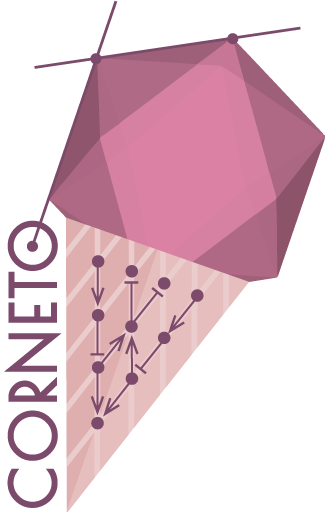

In [1]:
import corneto as cn

cn.info()

In [2]:
from corneto._data import GraphData

# Load dataset from tutorial
dataset = GraphData.load("data/carnival_transcriptomics_dataset.zip")

In [3]:
from corneto.methods.future import CarnivalFlow

m = CarnivalFlow(lambda_reg=0.1)
P = m.build(dataset.graph, dataset.data)
P.objectives

Unreachable vertices for sample: 0


[error_sample1_0: Expression(AFFINE, UNKNOWN, ()),
 multi_sample_regularization_edge_has_signal: Expression(AFFINE, NONNEGATIVE, ())]

In [4]:
# We will sample solutions by perturbing the edge_has_signal variable
P.expr

{'edge_inhibits': edge_inhibits: Variable((3374, 1), edge_inhibits, boolean=True),
 '_dag_layer': _dag_layer: Variable((970, 1), _dag_layer),
 '_flow': _flow: Variable((3374,), _flow),
 'edge_activates': edge_activates: Variable((3374, 1), edge_activates, boolean=True),
 'const0x16b856374e4a9f30': const0x16b856374e4a9f30: Constant(CONSTANT, NONNEGATIVE, (970, 3374)),
 'const0x72fe108f440b0c6': const0x72fe108f440b0c6: Constant(CONSTANT, NONNEGATIVE, (970, 3374)),
 'flow': _flow: Variable((3374,), _flow),
 'vertex_value': Expression(AFFINE, UNKNOWN, (970, 1)),
 'vertex_activated': Expression(AFFINE, NONNEGATIVE, (970, 1)),
 'vertex_inhibited': Expression(AFFINE, NONNEGATIVE, (970, 1)),
 'edge_value': Expression(AFFINE, UNKNOWN, (3374, 1)),
 'edge_has_signal': Expression(AFFINE, NONNEGATIVE, (3374, 1))}

## Sampling Solutions Using Random Perturbation

We'll implement a generic approach to sample alternative solutions by:
1. Introducing small random perturbations to the objective function
2. Re-optimizing the model with these perturbations
3. Collecting solutions that remain close to optimal (within a tolerance threshold)

This technique allows us to explore the space of near-optimal solutions and assess the robustness of different 
model components.

In [5]:
import numpy as np
import pandas as pd


def sample_alternative_solutions(
    problem,
    target_variable,
    percentage=0.1,
    scale=0.03,
    rel_opt_tol=0.05,
    max_samples=30,
    time_limit=60,
):
    """Sample alternative solutions by perturbing the objective function.

    Parameters:
    -----------
    problem : CORNETO optimization problem
        The optimization problem to sample
    target_variable : variable expression
        The variable to perturb (e.g., P.expr.edge_has_signal or P.expr.vertex_value)
    percentage : float
        Percentage of elements to perturb
    scale : float
        Scale parameter for normal distribution perturbation
    rel_opt_tol : float
        Relative optimality tolerance
    max_samples : int
        Maximum number of samples to generate
    time_limit : int
        Time limit for solver

    Returns:
    --------
    dict : A dictionary containing the results
    """
    # Save the original problem state
    original_problem = problem.solve(solver="gurobi", verbosity=1)

    # Store original objective values
    orig_objectives = []
    for o in problem.objectives:
        print(o.name, o.value)
        orig_objectives.append(o.value)

    # Prepare for perturbation
    shape = target_variable.shape
    num_elements = shape[0]
    n_elements = int(num_elements * percentage)
    vec = np.zeros(shape=num_elements)
    pert = problem.backend.Parameter("perturbation", shape=vec.shape, value=vec)

    # Add perturbation objective
    problem.add_objective(target_variable.T @ pert, name="perturbation")

    # Sample solutions
    selected_edges = []
    edge_values = []
    vertex_values = []

    for i in range(max_samples):
        # Generate random perturbation
        c = np.random.normal(scale=scale, size=n_elements)
        random_indices = np.random.choice(vec.shape[0], size=n_elements, replace=False)
        vec[:] = 0  # Reset vector
        vec[random_indices] = c

        # Update parameter and solve
        pert.value = vec
        solved_problem = problem.solve(
            solver="gurobi",
            warm_start=True,
            ignore_dpp=True,
            TimeLimit=time_limit,
            verbosity=0,
        )
        print(
            f"Sample {i + 1}/{max_samples}: Objective value = {solved_problem.value:.4f}"
        )

        # Check if solution is within tolerance
        accept = True
        for o_orig, o in zip(orig_objectives, problem.objectives):
            if o.name == "perturbation":
                continue
            relative_error = np.abs(o.value - o_orig) / np.abs(o_orig + 1e-10)
            print(f"  {o.name}: {o.value:.4f}, rel error: {relative_error:.4f}")
            if relative_error > rel_opt_tol:
                print(f"  > Rejected! ({relative_error:.4f} >= {rel_opt_tol})")
                accept = False
                break

        if accept:
            selected_edges.append(problem.expr.edge_has_signal.value > 0.5)
            edge_values.append(problem.expr.edge_value.value)
            vertex_values.append(problem.expr.vertex_value.value)

    return {
        "selected_edges": selected_edges,
        "edge_values": edge_values,
        "vertex_values": vertex_values,
    }

## Edge-Based Perturbation

First, we'll sample solutions by perturbing the edge variables. This allows us to explore
alternative network topologies where different edges might be selected.

In [6]:
# Create a fresh model
m = CarnivalFlow(lambda_reg=0.1)
P = m.build(dataset.graph, dataset.data)

# Sample solutions by perturbing edge_has_signal
edge_results = sample_alternative_solutions(
    problem=P,
    target_variable=P.expr.edge_has_signal,
    percentage=0.10,
    scale=0.03,
    rel_opt_tol=0.05,
    max_samples=30,
)

# Analyze edge-based results
df_sols = pd.DataFrame(
    np.concatenate(edge_results["selected_edges"], axis=1), index=m.processed_graph.E
).astype(int)
print(f"Generated {df_sols.shape[1]} alternative solutions")
df_sols.head()

Unreachable vertices for sample: 0
                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 10 07:10:17 PM: Your problem has 11092 variables, 31652 constraints, and 1 parameters.
(CVXPY) Apr 10 07:10:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 10 07:10:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 10 07:10:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 10 07:10:17 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Apr 10 07:10:17 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuf

,,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
(SMAD3),(MYOD1),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(GRK2),(BDKRB2),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(MAPK14),(MAPKAPK2),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(DEPTOR_EEF1A1_MLST8_MTOR_PRR5_RICTOR),(FBXW8),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(SLK),(MAP3K5),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Analyze variability in edge selection
df_var = pd.concat([df_sols.mean(axis=1), df_sols.std(axis=1)], axis=1)
df_var.columns = ["mean", "std"]
print("Edges with highest variability across solutions:")
df_var.sort_values(by="std", ascending=False).head(50).sort_values(by="mean")

Edges with highest variability across solutions:


,,mean,std
(PPP2CA),(RB1),0.300000,0.466092
(PML),(SMAD3),0.300000,0.466092
(MAPK1),(JUN),0.300000,0.466092
(GSK3B),(NFKB1_RELA),0.300000,0.466092
(MAPK3),(PML),0.333333,0.479463
(CTNNB1),(KLF4),0.333333,0.479463
(PHLPP1),(STK4),0.333333,0.479463
(GSK3B),(CDKN1A),0.366667,0.490133
(MAPK3),(GSK3B),0.366667,0.490133
(APC_AXIN1_GSK3B),(ROR2),0.400000,0.498273


In [8]:
# Analyze edge values across solutions
df_edge_val = pd.DataFrame(
    np.concatenate(edge_results["edge_values"], axis=1), index=m.processed_graph.E
).astype(int)
df_edge_val.head()

,,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
(SMAD3),(MYOD1),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(GRK2),(BDKRB2),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(MAPK14),(MAPKAPK2),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(DEPTOR_EEF1A1_MLST8_MTOR_PRR5_RICTOR),(FBXW8),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(SLK),(MAP3K5),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Vertex-Based Perturbation

Next, we'll sample solutions by perturbing vertex variables. This approach can highlight 
alternative active node sets that are consistent with the data.

In [9]:
# Create a fresh model
m = CarnivalFlow(lambda_reg=0.1)
P = m.build(dataset.graph, dataset.data)

# Sample solutions by perturbing vertex_value
vertex_results = sample_alternative_solutions(
    problem=P,
    target_variable=P.expr.vertex_value,
    percentage=0.10,
    scale=0.03,
    rel_opt_tol=0.05,
    max_samples=30,
)

# Analyze vertex-based results
df_vertex_val = pd.DataFrame(
    np.concatenate(vertex_results["vertex_values"], axis=1), index=m.processed_graph.V
).astype(int)
print(f"Generated {df_vertex_val.shape[1]} alternative solutions")
df_vertex_val.head()

Unreachable vertices for sample: 0
                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 10 07:11:09 PM: Your problem has 11092 variables, 31652 constraints, and 1 parameters.
(CVXPY) Apr 10 07:11:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 10 07:11:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 10 07:11:09 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 10 07:11:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Apr 10 07:11:09 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuf

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
DIAPH1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PRKD1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALDH2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MDM2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RAD21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Focus on signaling proteins with no measurement data
df_sig_prot_pred = df_vertex_val.loc[
    df_vertex_val.index.difference(dataset.data.query.pluck_features())
]
df_sig_prot_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
AAK1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABI1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABL1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ABL2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABRAXAS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


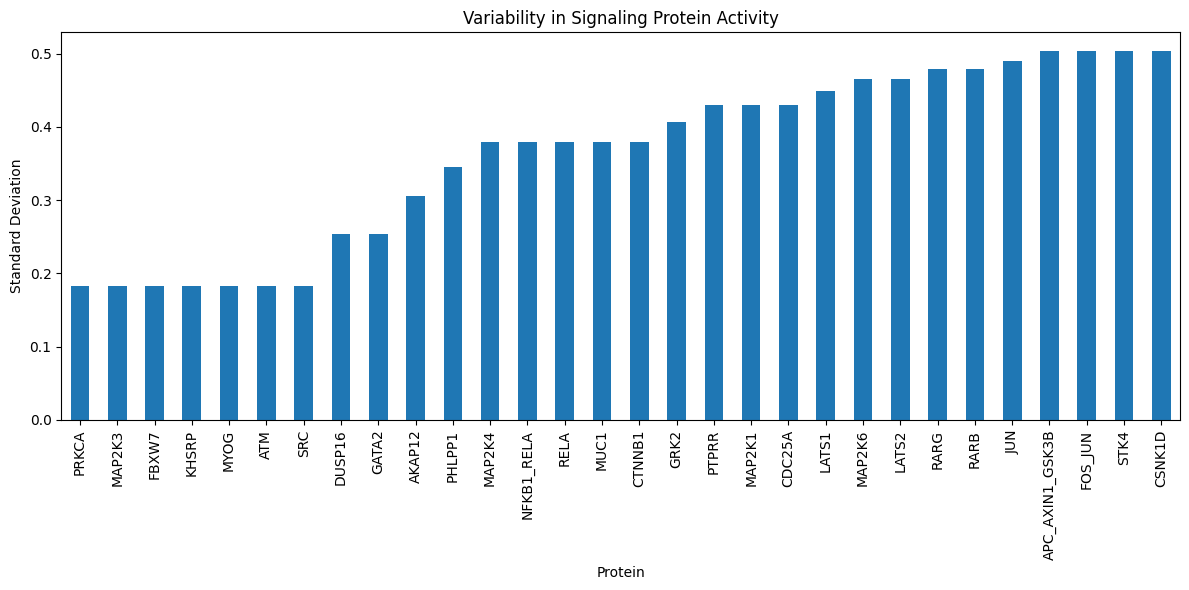

In [11]:
# Visualize the variability in predicted signaling protein activities
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_sig_prot_pred.std(axis=1).sort_values().tail(30).plot.bar(
    title="Variability in Signaling Protein Activity"
)
plt.xlabel("Protein")
plt.ylabel("Standard Deviation")
plt.tight_layout()
plt.show()

## Summary

In this notebook, we:

1. Created a generic sampling method for exploring alternative network solutions
2. Applied the method to both edge and vertex perturbations
3. Analyzed the variability in solutions to identify:
   - Edges with high uncertainty (appearing in some but not all solutions)
   - Signaling proteins with variable activity across solutions

This approach helps assess the robustness of network inference results and can guide 
further experimental validation efforts by highlighting the most uncertain parts of the network.